# Playing BlackJack: Monte-Carlo Simulations

## 1. Load Libraries

 First, let us import all the necessary libraries

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('seaborn-ticks')

## 2. Define Environment Specifics

 Simulate the Blackjack environment

In [2]:
env = gym.make('Blackjack-v0')

***Note:*** *There is only one "Blackjack" environment defined in OpenAI Gym*

In [3]:
[env for env in list(gym.envs.registry.env_specs.keys()) if env.startswith('Blackjack')]

['Blackjack-v0']

The objective of the popular casino card game of **blackjack** is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. Here, we consider the version in which each player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.

In the below snippet, we define a **policy function** which takes the current state and check if the score is greater than or equal to 20. By following this policy, If the *score is greater than or equal to 20* we *stand (0)* else we *hit (1)*.

In [4]:
def sample_policy(obs):
    score, dealer_score, usable_ace = obs
    return 0 if score >= 20 else 1

Each observation returned by the "Blackjack-v0" environment includes: i) the Player Score, ii) the Dealer Score and iii) If an "Ace" has been already used by player:

In [5]:
obs = env.reset()
print('observation: {}'.format(obs))
a = sample_policy(obs)
print('action: {}'.format(a))
env.step(a)

observation: (12, 7, False)
action: 1


((19, 7, False), 0.0, False, {})

## 3. Load Monte Carlo algorithms

### 3a. Load Plotting Utilities

Load a custom Python class of plotting utilities, `PlotUtils()`, and start a new instance.

In [6]:
%run ../PlotUtils.py

In [7]:
plotutls = PlotUtils()

### 3b. Load Monte Carlo Utilities class

Load a custom Python class of Monte Carlo algorithms, `MC_Utils()`, and start a new instance.

In [8]:
%run ../MC_Utils.py

In [9]:
mc = MC_Utils(env)

## 4. Monte Carlo Prediction algorithms (estimating $V \approx v_{\pi}$)

 Now that we learned how to generate an episode, we will see how to *perform* **First Vist MC Prediction**

### 4a. Approximate state-value functions after 100.000 episodes (first-visit MC)

In [10]:
s_values = mc.first_visit_mc_prediction(env, sample_policy, n_episodes=1e+4)

Let us see first few elements in the value table

In [11]:
for i in range(10):
  print(s_values.popitem())

((14, 9, True), -0.75)
((4, 9, False), -0.5)
((13, 5, True), 0.5)
((5, 3, False), -0.6)
((16, 1, True), -0.5454545454545454)
((6, 4, False), -0.3076923076923077)
((4, 8, False), -0.2857142857142857)
((17, 5, True), -0.2)
((17, 2, True), -0.38461538461538464)
((12, 5, True), -0.5)


 We define the function **`plot_blackjack()`** for plotting the value function and we can see how our value function is attaining the convergence. 

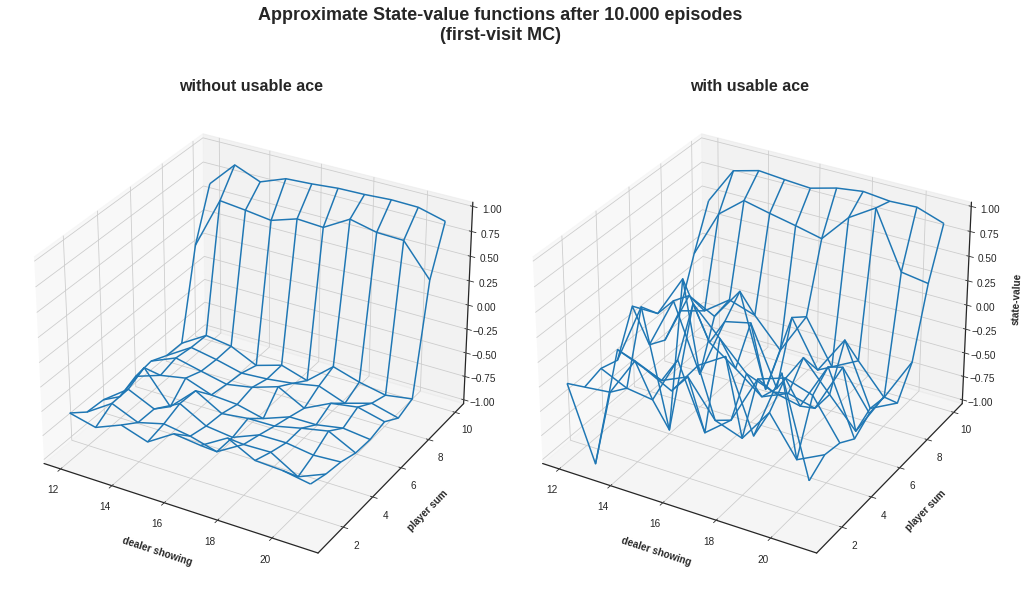

In [12]:
title = 'Approximate State-value functions after 10.000 episodes\n(first-visit MC)'
plotutls.plot_blackjack_1(s_values, title=title)

### 4b. Approximate state-value functions after 500.000 episodes (first-visit MC)

In [13]:
s_values = mc.first_visit_mc_prediction(env, sample_policy, n_episodes=5e+5)

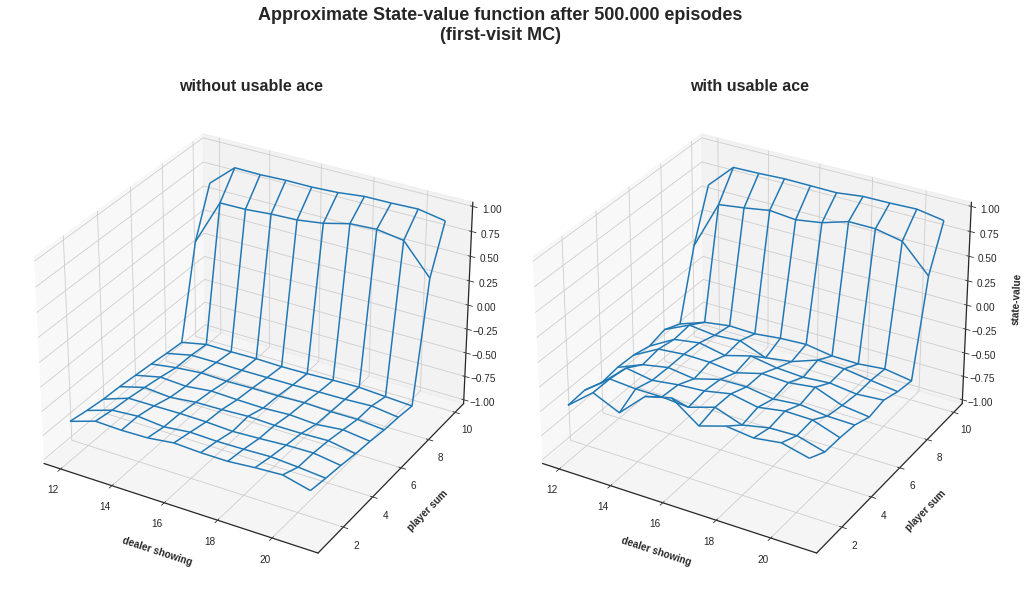

In [14]:
title = 'Approximate State-value function after 500.000 episodes\n(first-visit MC)'
plotutls.plot_blackjack_1(s_values, title=title)

## 5. Monte-Carlo Control algorithms

### 5a. Monte Carlo Exploring Starts (ES) [estimating $\pi \approx \pi_{*}$]

In [15]:
# Generalization of the np.argmax to break ties randomly when exist
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values

    Parameters
    ----------
    q_values : array_like
        Input array.
    
    Returns
    -------
    index_array : ndarray of ints
        The index of the highest value in q_values. Breaks ties randomly.
    """
    idxmax = [ix_ for ix_ in range(len(q_values)) 
              if q_values[ix_] == np.max(q_values)]
    return np.random.choice(idxmax)


# Behavior policy is greedy or epsilon-greedy (if epsilon > 0, but small)
def behavior_policy(obs, q_values, q_values_count, epsilon=0):
    '''
    Define greedy behavior policy using numpy array to keep q_values table.
    '''
    # Reset state indices to appropriately refer state in q_values numpy array
    player_sum, dealer_card, usable_ace = obs
    player_sum -= 12; dealer_card -= 1; usable_ace = int(usable_ace)
    
    # Get average returns for the possible state-action pairs and current state
    q_values_ = (q_values[player_sum, dealer_card, usable_ace,:] / 
                 q_values_count[player_sum, dealer_card, usable_ace,:])
    
    # Return the argmax of the action values list for current state (break ties randomly)
    a_star = argmax(q_values_)
    greedy_prob = 1
    
    if epsilon > 0:
        assert(epsilon < 1)
        non_greedy_prob = epsilon / q_values.size
        greedy_prob = 1 - epsilon + non_greedy_prob
        a_star = np.random.binomial(1, greedy_prob)
        
    return a_star, greedy_prob 


def target_default_policy(obs):
    '''
    Define the target policy we would like to achieve
    '''
    # Define ideal player policy
    player_sum, dealer_card, usable_ace = obs
    return (0 if player_sum >= 20 else 1), 1

#### **Monte Carlo Exploring Starts (ES) [estimating $\pi \approx \pi_{*}$, (first-visit MC after 10.000 episodes)]**

In [16]:
n_episodes = 1e+4
q_values = mc.monte_carlo_es(env, behavior_policy, 
                             target_default_policy, n_episodes=n_episodes)

100%|██████████| 10000/10000 [00:01<00:00, 9644.71it/s]


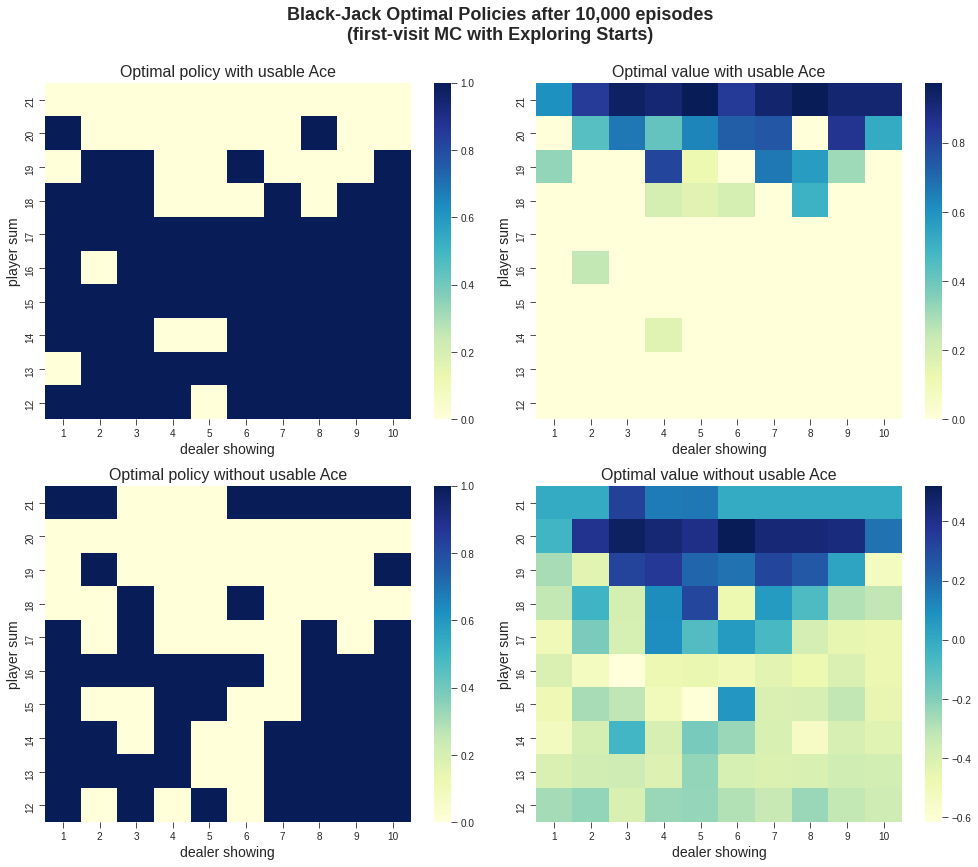

In [17]:
title = 'Black-Jack Optimal Policies after {0:,} episodes\n(first-visit MC with Exploring Starts)'.format(int(n_episodes), format_spec='d')
plotutls.plot_blackjack_2(q_values, suptitle=title)

#### **Monte Carlo with Exploring Starts (ES) [estimating $\pi \approx \pi_{*}$, (first-visit MC after 500.000 episodes)]**

In [18]:
n_episodes = 5e+5
q_values = mc.monte_carlo_es(env, behavior_policy, 
                             target_default_policy, n_episodes=n_episodes)

100%|██████████| 500000/500000 [00:55<00:00, 8996.42it/s]


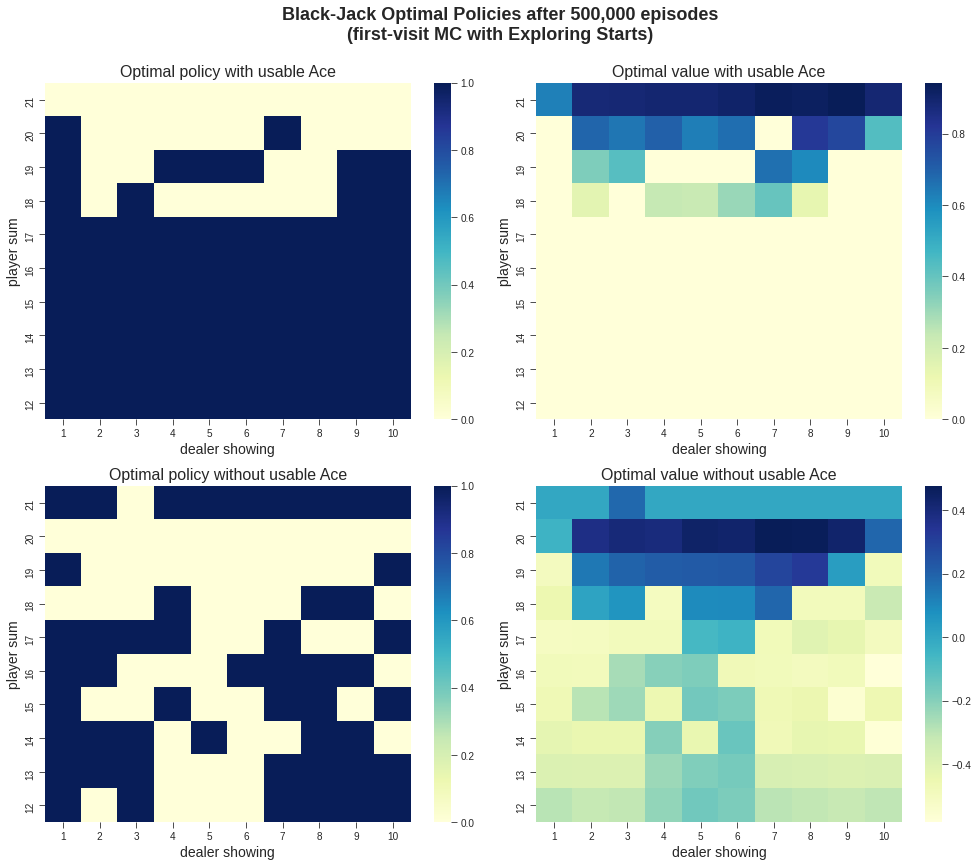

In [19]:
title = 'Black-Jack Optimal Policies after {0:,} episodes\n(first-visit MC with Exploring Starts)'.format(int(n_episodes), format_spec='d')
plotutls.plot_blackjack_2(q_values, suptitle=title)

### 5b. On-policy first-visit MC Control for $\varepsilon-\text{soft}$ policies [estimating $\pi\approx\pi_{*}$]

In [20]:
n_episodes = 5e+5; epsilon=0.35
q_values = mc.monte_carlo_on_policy(env, behavior_policy, 
                                    target_default_policy, n_episodes=n_episodes, epsilon=epsilon)

100%|██████████| 500000/500000 [01:01<00:00, 8195.15it/s]


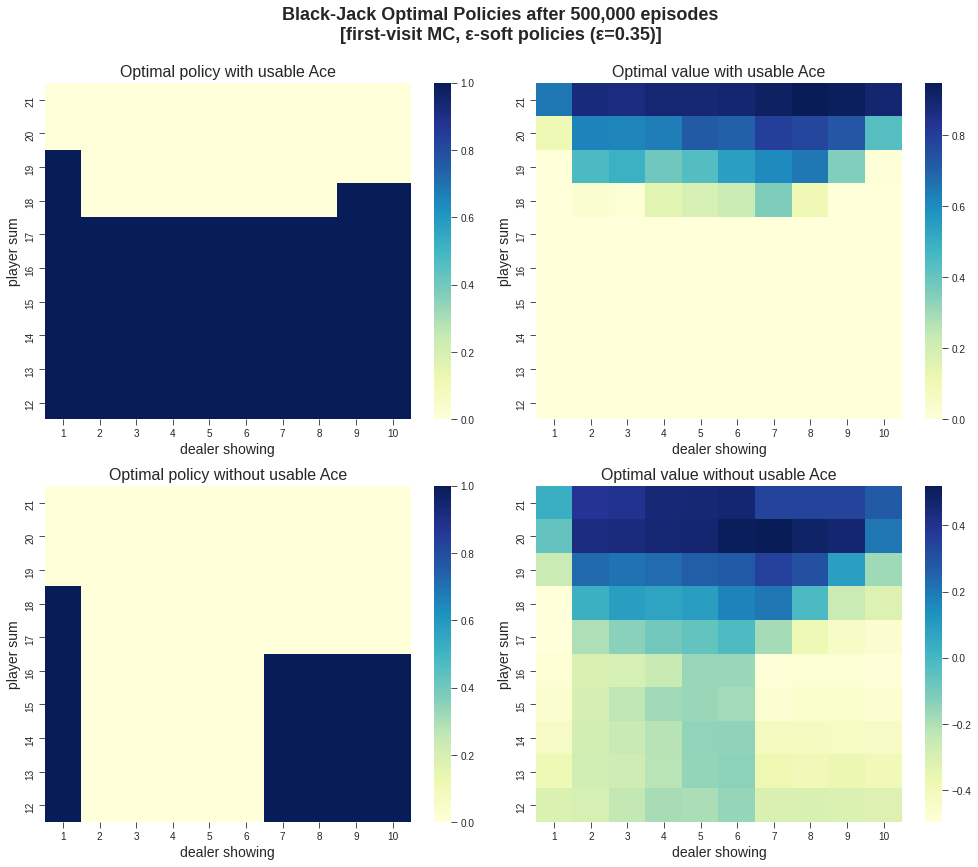

In [21]:
title = 'Black-Jack Optimal Policies after {0:,d} episodes\n[first-visit MC, ε-soft policies (ε={1:.2f})]'.format(int(n_episodes), epsilon)
plotutls.plot_blackjack_2(q_values, suptitle=title)

### 5c. Off-policy every-visit MC Prediction [Policy Evaluation (estimating $Q\approx q_{\pi}$)]

#### **Using Weighted Importance Sampling**

In [22]:
# Define a random behavior policy
def behavior_random_policy(obs):
    return np.random.binomial(1, 0.5), 0.5

In [23]:
n_episodes = 5e+5
q_values = mc.monte_carlo_off_policy_prediction(env, behavior_random_policy,
                                                target_default_policy, n_episodes=n_episodes)

100%|██████████| 500000/500000 [00:31<00:00, 15681.38it/s]


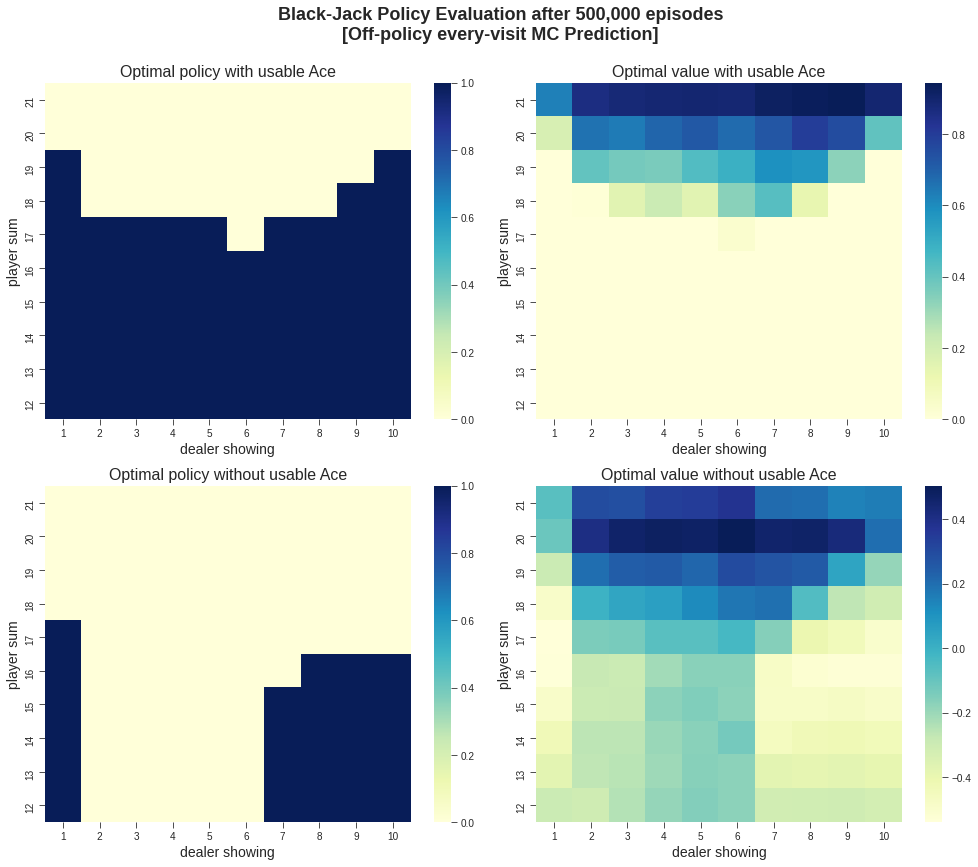

In [24]:
title = 'Black-Jack Policy Evaluation after {0:,d} episodes\n[Off-policy every-visit MC Prediction]'.format(int(n_episodes))
plotutls.plot_blackjack_2(q_values, suptitle=title)

### 5d. Off-policy every-visit MC Control [estimating $\pi\approx \pi_{*}$]

#### **Using Weighted Importance Sampling**

In [25]:
n_episodes = 5e+6; epsilon=0.75
q_values, pi_values = mc.monte_carlo_off_policy_control(env, behavior_policy,
                                                        target_default_policy, n_episodes=n_episodes, epsilon=epsilon)

100%|██████████| 5000000/5000000 [09:38<00:00, 8643.45it/s]


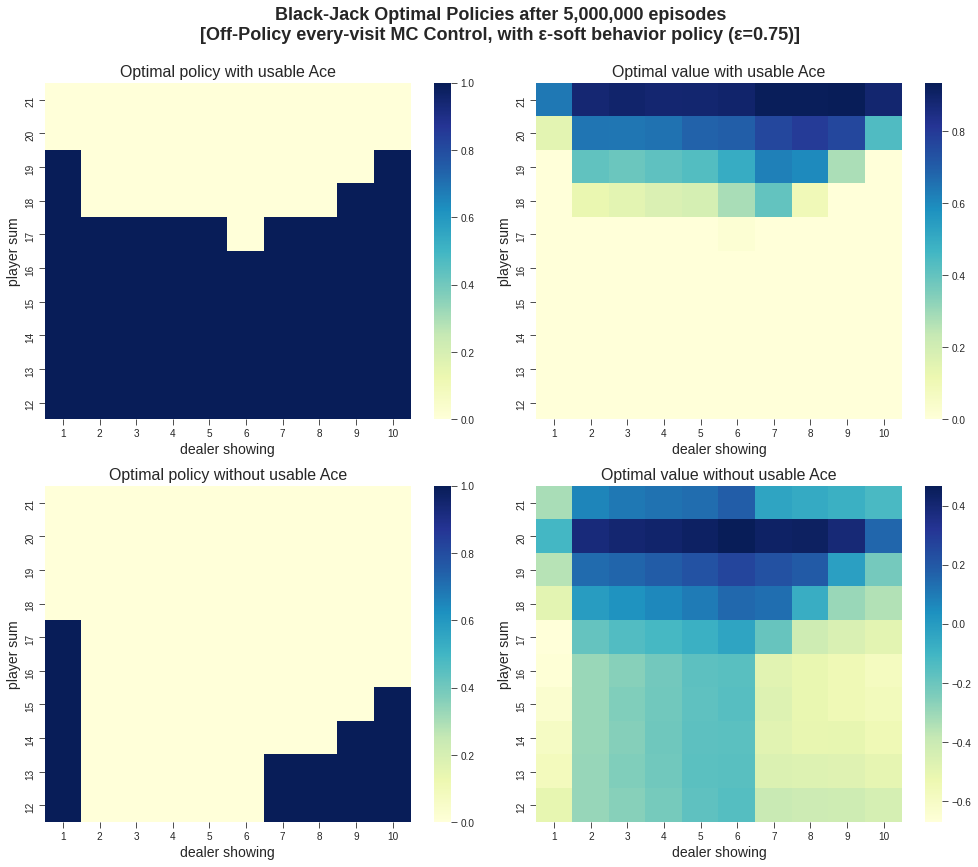

In [26]:
title=('Black-Jack Optimal Policies after {0:,d} episodes\n[Off-Policy every-visit MC Control, with ε-soft behavior policy (ε={1:.2f})]'
       .format(int(n_episodes), epsilon))
plotutls.plot_blackjack_3(q_values, pi_values, suptitle=title)